In [38]:
# Generate the enrcihed_data.csv dataset that is used for topic modelling experiments. 
# Combines app store data with app store data fetched from the App Store using 
# the iTunes API. 

import json
import pandas as pd
import os
import re
import requests
import csv
import matplotlib.pyplot as plt
import numpy as np

DEBUG = False

In [3]:
if not DEBUG:
    df = pd.read_csv('appleAppData.csv')


In [4]:
if DEBUG:
    # create a smaller sample of 1% of the original rows for development purposes 
    !head -1 appleAppData.csv > sample.csv
    !awk 'BEGIN  {srand()} !/^$/  { if (rand() <= .01 || FNR==1) print >> "sample.csv"}' appleAppData.csv
    #
    #
    df = pd.read_csv('sample.csv')

    df.columns

In [5]:
# Filter games only from the dataset
df = df.query("Primary_Genre == 'Games'")
df = df.dropna()
# Drop unneeded columns
df = df.drop(['Primary_Genre', 'Size_Bytes', 'Required_IOS_Version', 'Version', 'Price', 'Currency', 'Developer','Developer_Url','Developer_Website', 'Current_Version_Score', 'Current_Version_Reviews'], axis=1)

In [6]:
# Extract the app store id that can be used for querying the App Store API
def extract_numeric_app_id(row):
    # The app store id is in the format '/id[0-9]{9}' at the end of the URL. 
    # We only want the numeric part of the id, hence the ()'s
    matches = re.findall('id([0-9]{9})', row)
    if len(matches) == 0:
        print('No id found for row ', row)
        return None
    else:
        return matches[0]

df['AppStoreId'] = df['AppStore_Url'].apply(extract_numeric_app_id)
df['AppStoreId']

21         943274708
23         126382794
32         552864558
100        352871101
118        639537194
             ...    
1213920    377912125
1218816    124469544
1221824    154654196
1224010    154045177
1228531    128230260
Name: AppStoreId, Length: 82722, dtype: object

In [7]:
df.shape

(82722, 11)

In [140]:
# tmp extra filtering 
#df = df.head(10)
#df

In [189]:

def getGameDescription(appStoreId):
    itunesUrl = 'https://itunes.apple.com/lookup?id=' + str(appStoreId)
    fields = [None, None, None]
    body = None
    
    # Check local cache before doing a request
    cachePath = 'store_data/' + str(appStoreId) +'.json'
    if (os.path.isfile(cachePath)):
        f = open(cachePath) 
        body = json.load(f)    
    else:  
        try:
            response = requests.get(itunesUrl)
            if (response.status_code == 200):        
                body = json.loads(response.text)
                # write response to cache directory
                with open(cachePath, 'w') as outfile:
                    json.dump(body, outfile)
            else:
                if DEBUG: print ("Failed to retrieve results for " + str(appStoreId))
                return fields

        except requests.exceptions.Timeout:
            print('AppStore request timed out for ' + str(appStoreId))
            raise SystemExit(e)
        except requests.exceptions.RequestException as e:
            # catastrophic error. bail.
            raise SystemExit(e)        
        
    if (body['resultCount'] == 1 ):
        result = body['results'][0]
        if ('genreIds' in result and 'description' in result):
            fields = [
                result['genres'], # appStoreGenres
                result['genreIds'], # appStoreGenreIds
                result['description'], # Description
                result['languageCodesISO2A'], # GameLanguages
            ]
        else:
            if DEBUG: print ('Unexpected results')
            if DEBUG: print (body)
    else:   
        if DEBUG: print ("No results found for id " + str(appStoreId))
        return fields
    
    return fields

df[['AppStoreGenres', 'AppStoreGenreIds', 'Description', 'GameLanguages']] = df.apply(lambda x : getGameDescription(x['AppStoreId']), axis='columns', result_type='expand')
df['AppName'] = df['App_Name'] # normalize the naming 
df = df.dropna()
df

# TODO drop unnecessary columns and finalize the column names


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenreIds,Description,GameLanguages,WordCount,WordCounts,AppStoreGenres,appStoreGenres,convertedAppStoreGenres,AppName
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,1.0,419456907.0,5.00000,1.0,943274708,"[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",19.0,19,"[Games, Role Playing, Adventure, Books]","[Games, Role Playing, Adventure, Books]","[Games, Game Role Playing, Game Adventure, Books]",AAA³ Little Ponies & Unicorns
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,0.0,318996102.0,3.20000,5.0,352871101,"[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],377.0,377,"[Games, Books, Role Playing]","[Games, Books, Role Playing]","[Games, Books, Game Role Playing]",GA1: An Assassin in Orlandes
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,1.0,447370352.0,5.00000,1.0,639537194,"[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],137.0,137,"[Games, Books, Family]","[Games, Books, Family]","[Games, Books, Game Family]",Baby Games App (by HAPPYTOUCH®)
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,1.0,447370352.0,5.00000,1.0,623194607,"[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN],137.0,137,"[Games, Family, Books]","[Games, Family, Books]","[Games, Game Family, Books]",Baby Games from HAPPYTOUCH®
289,com.eblong.hadeanlands,Hadean Lands,https://apps.apple.com/us/app/hadean-lands/id9...,9+,2014-10-31T18:09:06Z,2018-12-31T13:05:55Z,0.0,457956106.0,5.00000,9.0,918958300,"[6014, 7012, 6018]",*Winner of the XYZZY Interactive Fiction Award...,[EN],226.0,226,"[Games, Puzzle, Books]","[Games, Puzzle, Books]","[Games, Game Puzzle, Books]",Hadean Lands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165471,com.cherrypickgames.touchdownhero.mac,Touchdown Hero: New Season,https://apps.apple.com/us/app/touchdown-hero-n...,4+,2015-11-05T07:27:01Z,2015-11-05T07:27:01Z,0.0,914892983.0,0.00000,0.0,974977700,"[6014, 7016, 6004, 7003]",NEW SEASON is finally here!\n\n- Get on the fi...,[EN],65.0,65,"[Games, Sports, Sports, Casual]","[Games, Sports, Sports, Casual]","[Games, Game Sports, Sports, Game Casual]",Touchdown Hero: New Season
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,1.0,999167300.0,4.68966,29.0,966960359,"[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],208.0,208,"[Games, Puzzle, Travel, Role Playing]","[Games, Puzzle, Travel, Role Playing]","[Games, Game Puzzle, Travel, Game Role Playing]",Hidden Objects USA Time Object
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,1.0,441029909.0,0.00000,0.0,664618541,"[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],119.0,119,"[Games, Simulation, Casino, Sports]","[Games, Simulation, Casino, Sports]","[Games, Game Simulation, Game Casino, Sports]",Slots! Golden Cherry
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,0.0,551147390.0,0.00000,0.0,555829723,"[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],274.0,274,"[G

In [164]:
print('Number of rows:', len(df))
df

Number of rows: 13174


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenreIds,Description,GameLanguages,WordCount,WordCounts,AppStoreGenres,appStoreGenres,convertedAppStoreGenres
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,1.0,419456907.0,5.00000,1.0,943274708,"[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",19.0,19,"[Games, Role Playing, Adventure, Books]","[Games, Role Playing, Adventure, Books]","[Games, Game Role Playing, Game Adventure, Books]"
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,0.0,318996102.0,3.20000,5.0,352871101,"[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],377.0,377,"[Games, Books, Role Playing]","[Games, Books, Role Playing]","[Games, Books, Game Role Playing]"
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,1.0,447370352.0,5.00000,1.0,639537194,"[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],137.0,137,"[Games, Books, Family]","[Games, Books, Family]","[Games, Books, Game Family]"
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,1.0,447370352.0,5.00000,1.0,623194607,"[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN],137.0,137,"[Games, Family, Books]","[Games, Family, Books]","[Games, Game Family, Books]"
289,com.eblong.hadeanlands,Hadean Lands,https://apps.apple.com/us/app/hadean-lands/id9...,9+,2014-10-31T18:09:06Z,2018-12-31T13:05:55Z,0.0,457956106.0,5.00000,9.0,918958300,"[6014, 7012, 6018]",*Winner of the XYZZY Interactive Fiction Award...,[EN],226.0,226,"[Games, Puzzle, Books]","[Games, Puzzle, Books]","[Games, Game Puzzle, Books]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165471,com.cherrypickgames.touchdownhero.mac,Touchdown Hero: New Season,https://apps.apple.com/us/app/touchdown-hero-n...,4+,2015-11-05T07:27:01Z,2015-11-05T07:27:01Z,0.0,914892983.0,0.00000,0.0,974977700,"[6014, 7016, 6004, 7003]",NEW SEASON is finally here!\n\n- Get on the fi...,[EN],65.0,65,"[Games, Sports, Sports, Casual]","[Games, Sports, Sports, Casual]","[Games, Game Sports, Sports, Game Casual]"
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,1.0,999167300.0,4.68966,29.0,966960359,"[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],208.0,208,"[Games, Puzzle, Travel, Role Playing]","[Games, Puzzle, Travel, Role Playing]","[Games, Game Puzzle, Travel, Game Role Playing]"
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,1.0,441029909.0,0.00000,0.0,664618541,"[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],119.0,119,"[Games, Simulation, Casino, Sports]","[Games, Simulation, Casino, Sports]","[Games, Game Simulation, Game Casino, Sports]"
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,0.0,551147390.0,0.00000,0.0,555829723,"[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],274.0,274,"[Games, Simulation, Utilities]","[Games, Simulation, Utilities]","[Games, Game Simulation, Utilities]"


In [165]:
# Filter out non english games (note that this will still leave some non-english game 
# descriptions since the data doesn't always seem to be correct!)
df = df[df['GameLanguages'].str.contains('EN', regex=False)]


In [166]:
if DEBUG: df.to_csv('enriched_sample.csv')
if not DEBUG: df.to_csv('enriched_data.csv')

In [190]:
df.sample(1)

,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenreIds,Description,GameLanguages,WordCount,WordCounts,AppStoreGenres,appStoreGenres,convertedAppStoreGenres,AppName
1137348,com.makeitsostudios.sm.bball.ios,Basketball General Manager,https://apps.apple.com/us/app/basketball-gener...,4+,2015-06-24T22:23:13Z,2020-05-01T14:51:23Z,1.0,376400110.0,2.83333,72.0,968510382,"[6014, 7015, 7016, 6004]",Manage your team to a Championship!\n\nBuild t...,[EN],168.0,168,"[Games, Simulation, Sports, Sports]","[Games, Simulation, Sports, Sports]","[Games, Game Simulation, Game Sports, Sports]",Basketball General Manager


In [197]:
df.loc[1137348]

App_Id                                      com.makeitsostudios.sm.bball.ios
App_Name                                          Basketball General Manager
AppStore_Url               https://apps.apple.com/us/app/basketball-gener...
Content_Rating                                                            4+
Released                                                2015-06-24T22:23:13Z
Updated                                                 2020-05-01T14:51:23Z
Free                                                                     1.0
DeveloperId                                                      376400110.0
Average_User_Rating                                                  2.83333
Reviews                                                                 72.0
AppStoreId                                                         968510382
AppStoreGenreIds                                    [6014, 7015, 7016, 6004]
Description                Manage your team to a Championship!\n\nBuild t...

In [167]:
# calculate the word counts for the descriptions 

def get_word_count(desc):
    return len(desc.split())

WordCounts = df['Description'].apply(get_word_count)
df['WordCounts'] = WordCounts
df['WordCounts'].describe()

count    13174.000000
mean       215.768559
std        144.647162
min          1.000000
25%        104.000000
50%        185.500000
75%        291.000000
max        796.000000
Name: WordCounts, dtype: float64

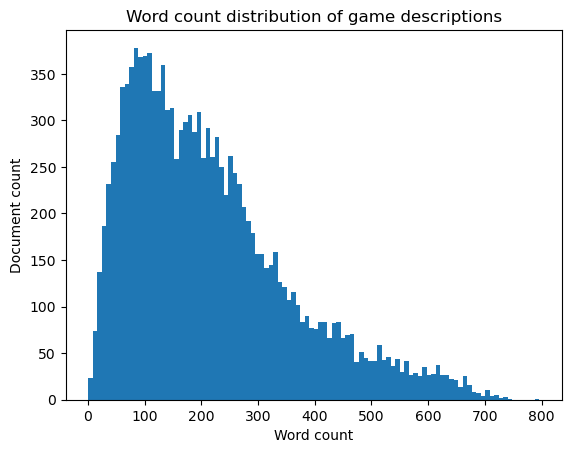

In [168]:
# Histogram about the description lengths
counts, bins = np.histogram(df['WordCounts'], bins=100)
plt.stairs(counts, bins, fill=True)
plt.xlabel('Word count')
plt.ylabel('Document count')
plt.title('Word count distribution of game descriptions')
plt.show()

In [169]:
df.where(df['WordCount'] == 1)['Description'].dropna()

552917    作業TipOn將學生需要練習的作業數位遊戲化。作業TipOn提供不同的遊戲模組，讓學生可以透...
Name: Description, dtype: object

In [170]:
df['AppStoreGenreIds'].describe()


count                  13174
unique                  1621
top       [6014, 7009, 6017]
freq                     222
Name: AppStoreGenreIds, dtype: object

In [178]:
# These mappings are from https://developers.apptweak.com/reference/app-store-categories
# This is used just to check that the genreIds and genres match in the 
# response from the app store API

# Note that these mappings are not in the end used as we use the genre names extracted
# from the API directly. It has been part of the exploratory data analysis to inspect whether
# these codes work as expected or not.
category_mappings = {
    '6000': 'Business',
    '6001': 'Weather',
    '6002': 'Utilities',
    '6003': 'Travel',
    '6004': 'Sports',
    '6005': 'Social Networking',
    '6006': 'Reference',
    '6007': 'Productivity',
    '6008': 'Photo & Video',
    '6009': 'News',
    '6010': 'Navigation',
    '6011': 'Music',
    '6012': 'Lifestyle',
    '6013': 'Health & Fitness',
    '6014': 'Games',
    '6015': 'Finance',
    '6016': 'Entertainment',
    '6017': 'Education',
    '6018': 'Books',
    '6020': 'Medical',
    '6021': 'Newsstand',
    '6022': 'Catalogs',
    '6023': 'Food & Drink',
    '6024': 'Shopping',
    '6027': 'Graphics & Design',
    '7001': 'Game Action',
    '7002': 'Game Adventure',
    '7003': 'Game Casual',
    '7004': 'Game Board',
    '7005': 'Game Card',
    '7006': 'Game Casino',
    '7007': 'Game Dice',
    '7008': 'Game Educational',
    '7009': 'Game Family',
    '7010': 'Game Kids',
    '7011': 'Game Music',
    '7012': 'Game Puzzle',
    '7013': 'Game Racing',
    '7014': 'Game Role Playing',
    '7015': 'Game Simulation',
    '7016': 'Game Sports',
    '7017': 'Game Strategy',
    '7018': 'Game Trivia',
    '7019': 'Game Word'
}
    
# convert the genre ids to genre strings

def convert_genre_id_to_str(id_array):
    genre_strings = [category_mappings[genre_id] for genre_id in id_array]
    return genre_strings

df['convertedAppStoreGenres'] = df['AppStoreGenreIds'].apply(convert_genre_id_to_str)

df[['AppStoreGenres', 'convertedAppStoreGenres']]

,AppStoreGenres,convertedAppStoreGenres
21,"[Games, Role Playing, Adventure, Books]","[Games, Game Role Playing, Game Adventure, Books]"
100,"[Games, Books, Role Playing]","[Games, Books, Game Role Playing]"
118,"[Games, Books, Family]","[Games, Books, Game Family]"
242,"[Games, Family, Books]","[Games, Game Family, Books]"
289,"[Games, Puzzle, Books]","[Games, Game Puzzle, Books]"
...,...,...
1165471,"[Games, Sports, Sports, Casual]","[Games, Game Sports, Sports, Game Casual]"
1167789,"[Games, Puzzle, Travel, Role Playing]","[Games, Game Puzzle, Travel, Game Role Playing]"
1168772,"[Games, Simulation, Casino, Sports]","[Games, Game Simulation, Game Casino, Sports]"
1197497,"[Games, Simulation, Utilities]","[Games, Game Simulation, Utilities]"


Statistics about number of genres from the app store metadata
mean    2.547973
min     0.000000
max     3.000000
std     0.629205
Name: AppStoreGenres, dtype: float64


(array([0, 1, 2, 3]), array([  51,  823, 4156, 8144]))

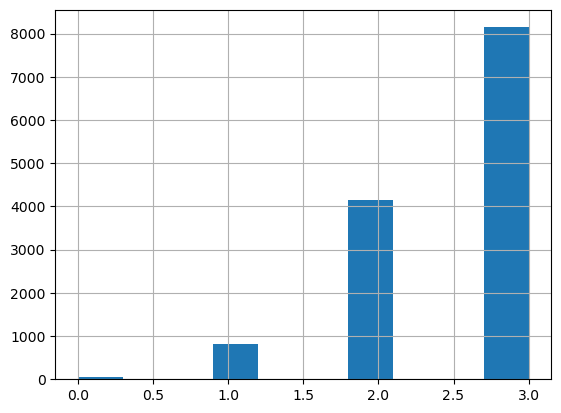

In [188]:
# -1 removes the shared 'Games' category that is included in every item
print("Statistics about number of genres from the app store metadata")
print((df['AppStoreGenres'].str.len()-1).agg(['mean','min', 'max','std']))


# Get counts of different number of genres listed for games
np.unique((df['AppStoreGenres'].str.len()-1), return_counts=True)
# draw histogram of the above
(df['AppStoreGenres'].str.len()-1).hist()


In [173]:
all_categories = np.array(sum(df['AppStoreGenres'].values.tolist(), []))
# convert codes to readable categories
all_categories = list(filter(lambda x : x != 'Games', all_categories))
# drop the Game category since it's in all items



<AxesSubplot:title={'center':'Distribution of App Store genre labels'}, xlabel='Genre'>

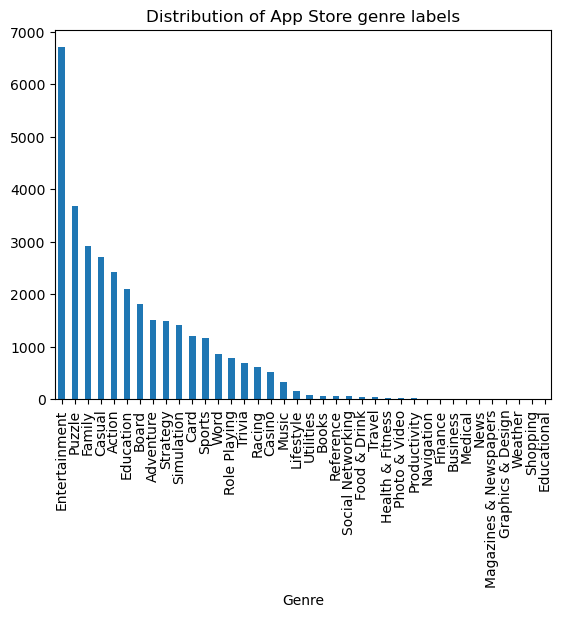

In [174]:
categories_df = pd.Series(all_categories, dtype='category')

categories_df.value_counts().plot.bar(title='Distribution of App Store genre labels', xlabel='Genre')


#plt.hist(all_categories, bins=len(set(all_categories)), fill=True)
#plt.xlabel('Genre')
#plt.xticks(rotation=90)
#plt.title('Distribution of App Store genre labels')
#plt.show()


,AppStoreGenres,convertedAppStoreGenres
21,"[Games, Role Playing, Adventure, Books]","[Games, Game Role Playing, Game Adventure, Books]"
100,"[Games, Books, Role Playing]","[Games, Books, Game Role Playing]"
118,"[Games, Books, Family]","[Games, Books, Game Family]"
242,"[Games, Family, Books]","[Games, Game Family, Books]"
289,"[Games, Puzzle, Books]","[Games, Game Puzzle, Books]"
...,...,...
1165471,"[Games, Sports, Sports, Casual]","[Games, Game Sports, Sports, Game Casual]"
1167789,"[Games, Puzzle, Travel, Role Playing]","[Games, Game Puzzle, Travel, Game Role Playing]"
1168772,"[Games, Simulation, Casino, Sports]","[Games, Game Simulation, Game Casino, Sports]"
1197497,"[Games, Simulation, Utilities]","[Games, Game Simulation, Utilities]"
